# Create a Graph Neural Network for LEAKSTREAM data

In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Pytorch Geometric
import torch_geometric.nn as geom_nn

# Progress Bar
from tqdm import tqdm

In [68]:
class Dataset:
    def __init__(self, identifier, mutator='pattern', timerange='720'):
        self.filename = f"{identifier}_bd_{mutator}_h_{timerange}_leak_area_0_"
        self.data, self.timesteps, self.n_nodes = self.load_data()
        
    @property
    def features(self):
        return ["pressure_value", "base_demand", "demand_value", "leak_demand_value"]
        
    def load_data(self):
        data = pd.read_csv(f"dati/networks/dataset-network-out/{self.filename}nodes.csv", sep=";")
        df = data[['hour', 'nodeID', 'pressure_value', 'base_demand', 'demand_value', 'leak_demand_value']]
        timesteps = df['hour'].unique()
        n_nodes = df['nodeID'].unique()
        
        # df.columns = ['hour', 'nodeID', 'p', 'b', 'd', 'l']
        df = df.pivot_table(index='hour', columns='nodeID', values=self.features)
        
        df.columns = ['_'.join((col[0], str(col[1]))) for col in df.columns]
        df.index = df.index.map(lambda x: int(x.split(":")[0]))
        df.sort_index(inplace=True)
        return df, timesteps, n_nodes
    
    def to_numpy(self):
        """This convert the data into a numpy array of shape (hour, n_nodes, n_features)"""
        timesteps = len(self.timesteps)
        n_nodes = len(self.n_nodes)
        features = len(self.features)
        return self.data.to_numpy().reshape(timesteps, features, n_nodes).swapaxes(1, 2)
    
    @property
    def adj_matrix(self):
        """
        This returns the adjacency matrix of the network. 
        The matrix is a pandas DataFrame with the nodes as columns and rows. 
        The value of the matrix is 1 if there is a link between the nodes, 0 otherwise.
        """
        links = pd.read_csv(f"dati/networks/dataset-network-out/{self.filename}links.csv", sep=";")
        # Filter only the first timestep
        links = links.loc[links['hour'] == self.timesteps[0], ['start_node', 'end_node']]
        matrix = np.zeros((len(self.n_nodes), len(self.n_nodes)))
        for i, start_node in enumerate(self.n_nodes):
            for j, end_node in enumerate(self.n_nodes):
                if end_node in links.loc[links['start_node'] == start_node, 'end_node'].values:
                    matrix[i, j] = 1
                    matrix[j, i] = 1
        return pd.DataFrame(matrix, columns=self.n_nodes, index=self.n_nodes)

In [74]:
dataset = Dataset('NET_0', '0_005', '720')
dataset.data.head()
adj_matrix = dataset.adj_matrix
adj_matrix

,880000,880001,880002,880003,880004,880005,880006,880007,880008,880009,880010,880011,880012
880000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
880001,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
880002,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
880003,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
880004,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
880005,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
880006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
880007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
880008,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
880009,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


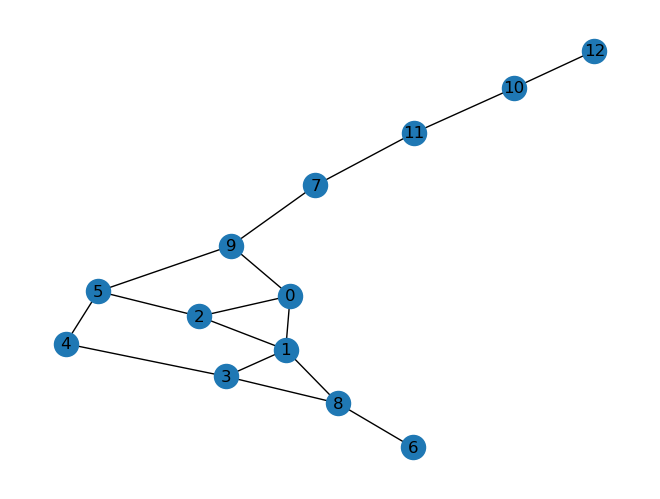

In [75]:
import networkx as nx
G = nx.from_numpy_array(adj_matrix.to_numpy())
 
nx.draw(G, with_labels=True)
plt.show()

In [23]:
class GNNModel(nn.Module):
    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        
        :param c_in: Dimensionality of input features .
        :param c_out: Dimensionality of output features.
        :param num_heads: Number of heads, i.e. attention mechanisms to apply in parallel. The output features are equally split up over the heads if concat_heads=True.
        :param concat_heads: If True, the output of the different heads is concatenated instead of averaged.
        :param alpha: Negative slope of the LeakyReLU activation.
        """
        super().__init__()

In [78]:
data = torch.tensor(dataset.to_numpy(), dtype=torch.float32)
data.shape

torch.Size([720, 13, 4])